In [140]:

import jax
import math 
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import jax.random as jr
import random

import flax
import optax
from flax import linen as nn
from flax.training import train_state

from tqdm import trange
from functools import partial

import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import optax as ox
from jaxtyping import install_import_hook

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx
 
# plt.rcParams['text.usetex'] = False

In [141]:
vertex_per_side = 20
n_edges_to_remove = 30
p = 0.8

G = nx.barbell_graph(vertex_per_side, 0)

random.seed(123)
[G.remove_edge(*i) for i in random.sample(list(G.edges), n_edges_to_remove)]

pos = nx.spring_layout(G, seed=123)  # positions for all nodes
L = nx.laplacian_matrix(G).toarray()
n = L.shape[0]

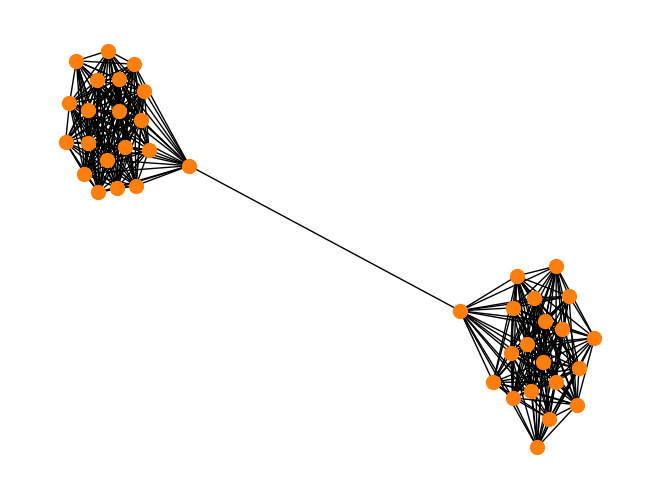

In [142]:
cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

nx.draw(
    G, pos, node_size=100, node_color=cols[1], edge_color="black", with_labels=False
)


In [143]:
from typing import NamedTuple, Any
import numpy as np
key = jr.PRNGKey(0)

class TimedX(NamedTuple):
  t: Any
  x: Any


In [144]:
# 
cov_0 = jax.scipy.linalg.inv(jnp.eye(n) + 0.1 * L)
cov_1 = jax.scipy.linalg.expm(-0.5 * L)
def gp_dynacmis(key, t):
    bs = t.shape[0]
    keys = jr.split(key, 2)
    x_0 = jr.multivariate_normal(keys[0], jnp.zeros(n), cov_0, shape=(bs,))
    x_1 = jr.multivariate_normal(keys[1], jnp.zeros(n), cov_1, shape=(bs,))
    return (1-t)* x_0 + t * x_1

In [145]:
bs = 512
t_axis = np.linspace(0.0, 1.0, 6)
x_t = []
q_t = gp_dynacmis
for t in t_axis:
  key, loc_key = jr.split(key)
  x_t.append(TimedX(t=t, x=q_t(loc_key, t*np.ones([bs,1]))))

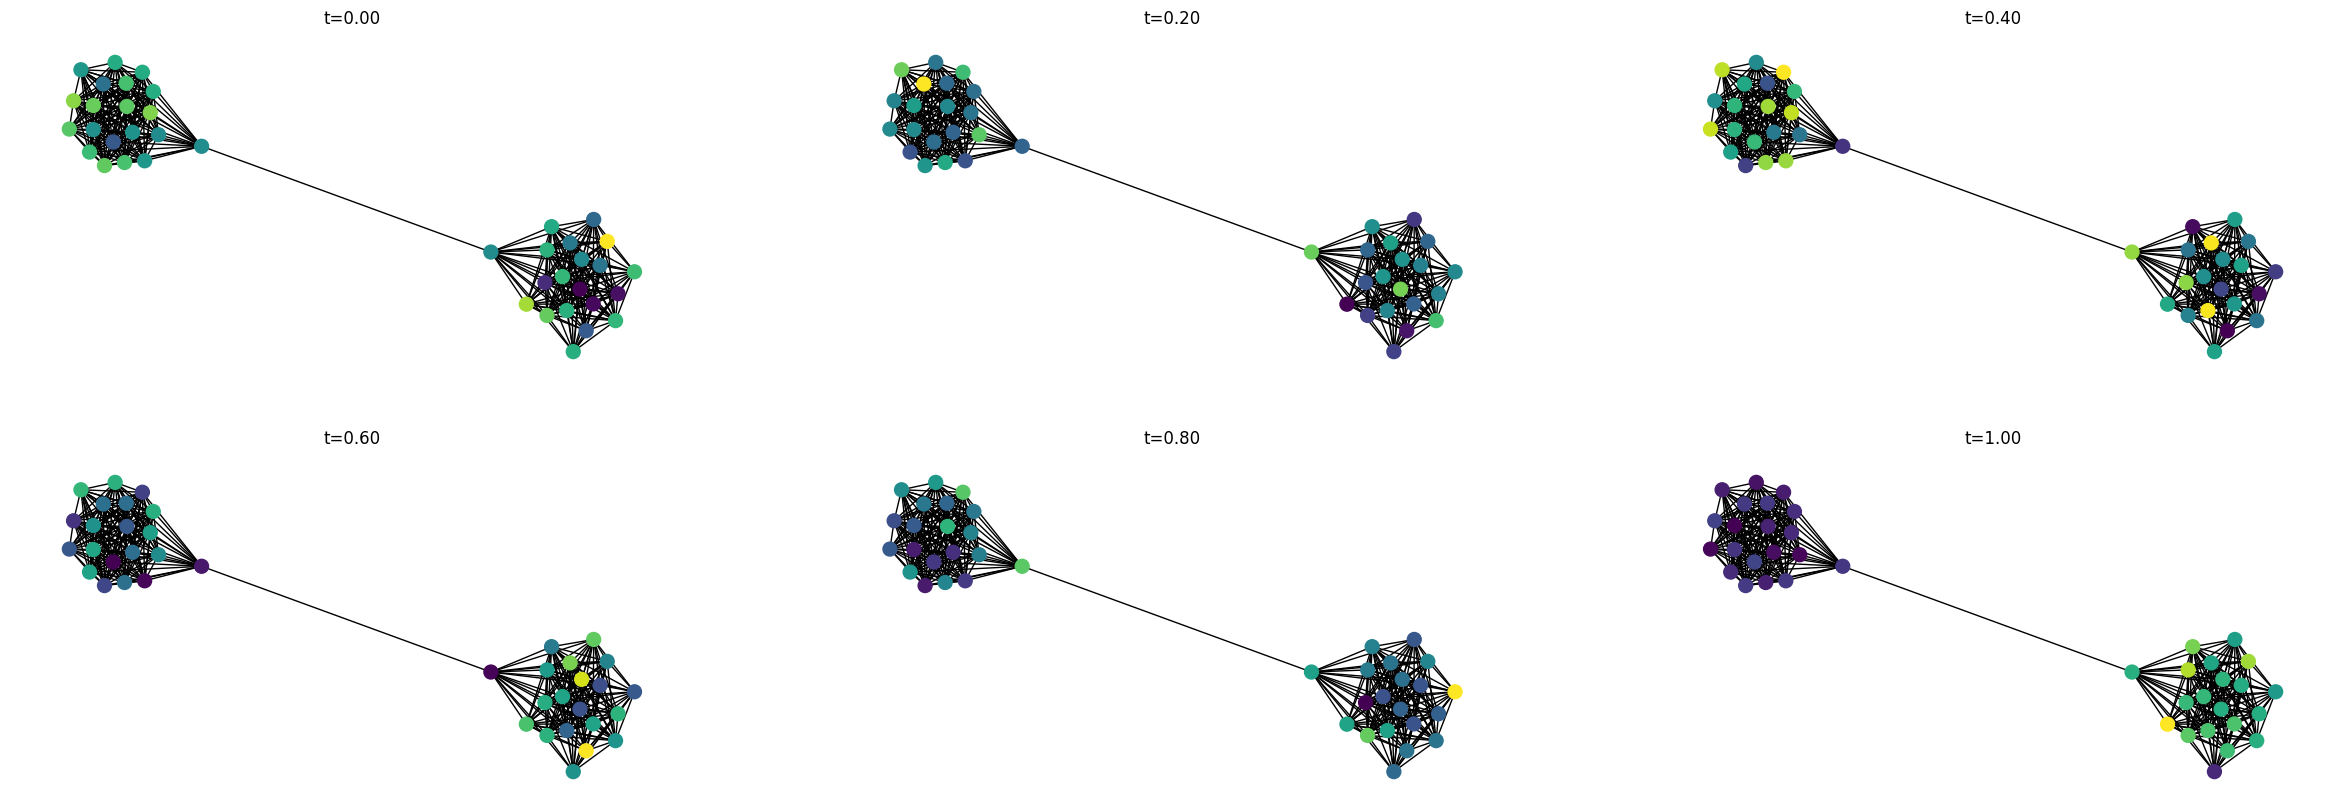

In [146]:
# for each time, we plot the data on the graph. use two rows to show the data
fig, axs = plt.subplots(2, 3, figsize=(30, 10))
axs = axs.flatten()
for i, (t, x) in enumerate(x_t):
  nx.draw(
      G,
      pos,
      node_size=100,
      node_color=x[0],
      edge_color="black",
      with_labels=False,
      ax=axs[i],
  )
  axs[i].set_title(f"t={t:.2f}")

In [147]:
class MLP(nn.Module):
  num_hid : int
  num_out : int

  def setup(self):
    self.linear1 = nn.Dense(features=self.num_hid)
    self.linear2 = nn.Dense(features=self.num_hid)
    self.linear3 = nn.Dense(features=self.num_hid)
    self.linear4 = nn.Dense(features=self.num_out)

  def __call__(self, t, x):
    h = jnp.hstack([t,x])
    h = self.linear1(h)
    h = nn.relu(h)
    h = self.linear2(h)
    h = nn.swish(h)
    h = self.linear3(h)
    h = nn.swish(h)
    h = self.linear4(h)
    return h

In [148]:
def sample_t(u0, n, t0=0.0, t1=1.0):
  u = (u0 + math.sqrt(2)*np.arange(n + 1)) % 1
  u = u.reshape([-1,1])
  return u[:-1]*(t1-t0) + t0, u[-1]

In [149]:
model = MLP(num_hid=512, num_out=1)
print(model)

key, init_key = jr.split(key)
params = model.init(init_key, x_t[0].t*np.ones([bs,1]), x_t[0].x)

optimizer = optax.adam(learning_rate=2e-4)
state = train_state.TrainState.create(apply_fn=model.apply,
                                      params=params,
                                      tx=optimizer)

# derivatives of the model are necessary to define the AM loss
dsdtdx = jax.grad(lambda p, t, x: state.apply_fn(p,t,x).sum(), argnums=[1,2])
# and to apply the model
dsdx = jit(jax.grad(lambda p, t, x: state.apply_fn(p,t,x).sum(), argnums=2))

MLP(
    # attributes
    num_hid = 512
    num_out = 1
)


In [150]:
def am_loss(state, params, bs, u0, key):
  keys = jr.split(key)
  # boundaries
  t_0, t_1 = jnp.zeros([bs, 1]), jnp.ones([bs, 1])
  x_0, x_1 = q_t(keys[0], t_0), q_t(keys[1], t_1)
  loss = state.apply_fn(params, t_0, x_0) - state.apply_fn(params, t_1, x_1)

  # time
  t, u0 = sample_t(u0, bs)
  x_t = q_t(keys[2], t)
  dsdt, dsdx = dsdtdx(params, t, x_t)
  loss = loss + dsdt + 0.5*(dsdx**2).sum(1, keepdims=True)
  return loss.mean(), u0

@partial(jax.jit, static_argnums=1)
def train_step(state, bs, u0, key):
  grad_fn = jax.value_and_grad(am_loss, argnums=1, has_aux=True)
  (loss, u0), grads = grad_fn(state, state.params, bs, u0, key)
  state = state.apply_gradients(grads=grads)
  return state, loss, u0

key, loc_key = jr.split(key)
state, loss, u0 = train_step(state, bs, 0.5, loc_key)

In [151]:
num_iterations = 2_000
u0 = 0.5

loss_plot = np.zeros(num_iterations)
key, loop_key = jr.split(key)
for iter in trange(num_iterations):
  state, loss, u0 = train_step(state, bs, u0, jr.fold_in(loop_key, iter))
  loss_plot[iter] = loss

100%|██████████| 2000/2000 [01:39<00:00, 20.15it/s]


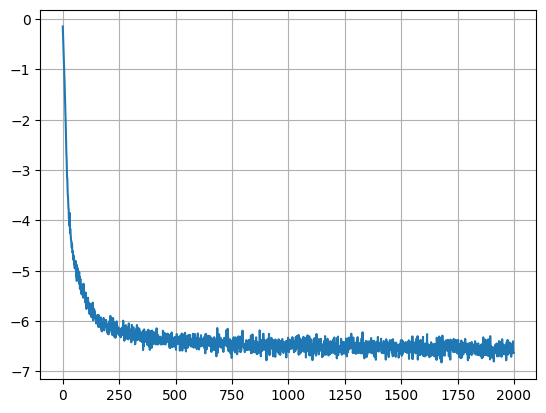

In [152]:

plt.plot(loss_plot)
plt.grid()

In [153]:
dt = 1e-2
t_0 = 0.0
n1 = int(1/dt)
key, *keys = jr.split(key, num=3)
x = [TimedX(t=t_0, x=q_t(keys[0], t_0*np.ones([2*bs,1])))]
true_x = [TimedX(t=t_0, x=q_t(keys[1], t_0*np.ones([2*bs,1])))]
for _ in trange(n1):
  x_ = x[-1].x + dt*dsdx(state.params, x[-1].t*np.ones([2*bs,1]), x[-1].x)
  t_ = x[-1].t + dt
  x.append(TimedX(t=t_, x=x_))
  key, loc_key = jr.split(key)
  true_x.append(TimedX(t=t_, x=q_t(loc_key, t_*np.ones([2*bs,1]))))

100%|██████████| 100/100 [00:01<00:00, 70.03it/s]


In [154]:
# list out the predicted and true data at time [0, 0.2, 0.4, 0.6, 0.8, 1.0] into two arrays 
x_pred = x[::20]
x_true = true_x[::20]

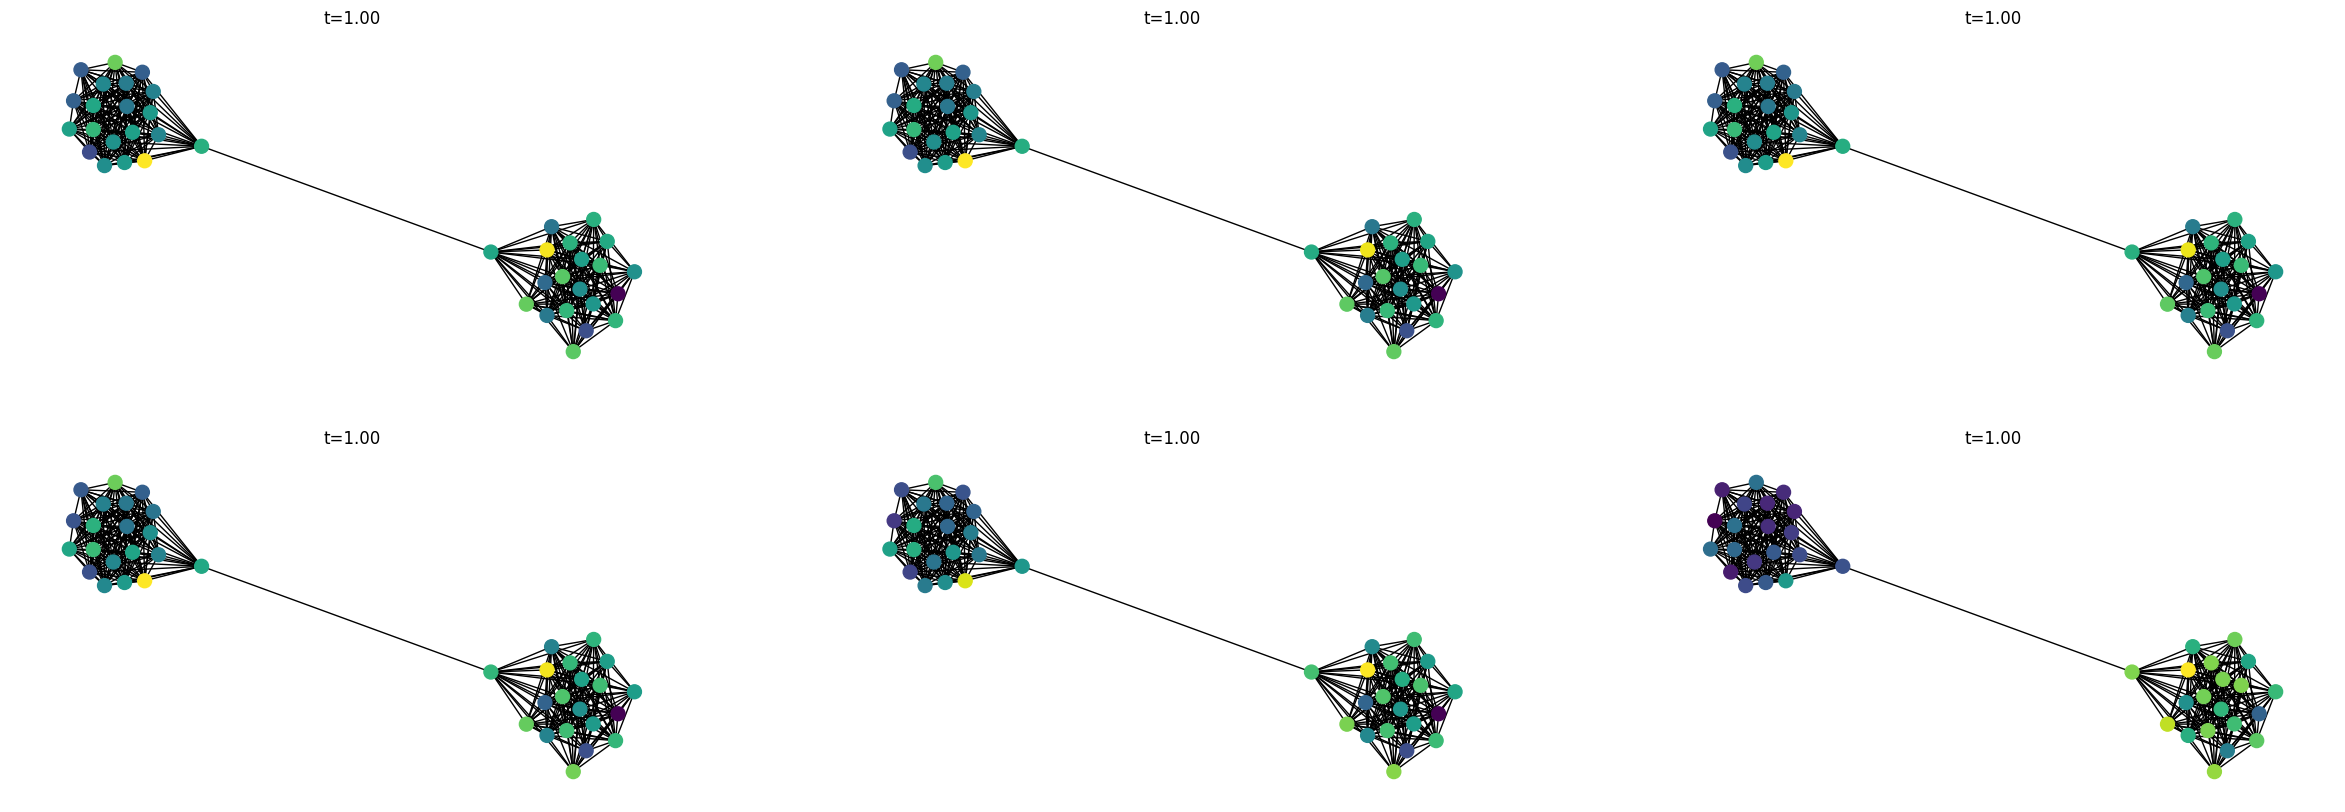

In [156]:
# for each time, we plot the data on the graph. use two rows to show the data
fig, axs = plt.subplots(2, 3, figsize=(30, 10))
axs = axs.flatten()
# consider time points [0, 0.2, 0.4, 0.6, 0.8, 1.0]

for i in np.arange(6):
  nx.draw(
      G,
      pos,
      node_size=100,
      node_color=x_pred[i].x[1],
      edge_color="black",
      with_labels=False,
      ax=axs[i],
  )
  axs[i].set_title(f"t={t:.2f}")

